In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os
from time import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

from utils import generate_run_id, get_input_args, Args
from models import Discriminator, Generator_MNIST, Weight_Clipper, G_weights_init
from data import load_MNIST
from metrics import get_IS, get_FID

In [3]:
# Random Seeding
torch.manual_seed(0)
np.random.seed(0)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, 
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4)
)

# Generate Run ID
run_id = generate_run_id(args)



run_id = "16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000"
# /home/jason/p2/runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
run_fp

'runs/16-12_100_32_1_inf_1e-06_0.4_0.005_0.0005_0.5_64_5_50000'

In [4]:
# Setup MNIST dataset
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(args.batch_size)

In [8]:
# Load the generator
G = Generator_MNIST(nz=args.nz, ngf=args.ngf, nc=args.nc).to(device)
G.load_state_dict(torch.load(os.path.join(run_fp, 'netG_36000.pt')))
G.eval()

Generator_MNIST(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [9]:
# Generate Sample Images
noise = torch.randn(32, 100, 1, 1).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)

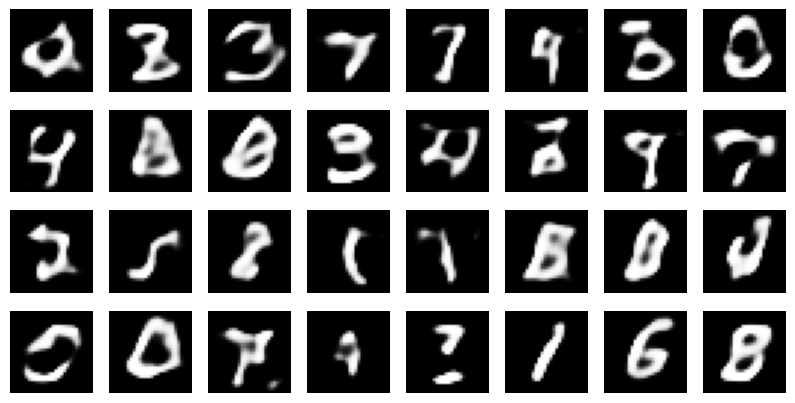

In [10]:
# Plot Sample Images
fig, ax = plt.subplots(4, 8, figsize=(10, 5))
for i in range(4):
    for j in range(8):
        ax[i, j].imshow(fake[i*8+j][0].detach().cpu().numpy(), cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [22]:
# Generate 2048 fake images
noise = torch.randn(2048, 100, 1, 1).to(device)
fake = G(noise)
fake = fake.view(fake.size(0), 1, 28, 28)

In [24]:
# Calculate Inception Score
IS = get_IS(fake)
print("Inception Score:", IS)

Inception Score: 2.657859978023734


In [25]:
# Calculate Frechet Inception Distance
FID = get_FID(fake)
print("Frechet Inception Distance:", FID)

  0%|          | 0/41 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/runpy.py", line 192, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pytorch_fid/fid_score.py", line 259, in calculate_fid_given_paths
    m1, s1 = compute_statistics_of_path(paths[0], model, batch_size,
  File "/home/jason/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pytorch_fid/fid_score.py", line 243, in compute_statistics_of_path
   

ValueError: could not convert string to float: ''